# Learning covariance dictionaries on simulated data

In [47]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [61]:
import covdict
import sys
import time
from numpy import (arange, argmax, argsort, corrcoef, cov, diag, diag_indices, dot, dstack, empty, floor, 
                   hsplit, hstack, max, roll, triu_indices, vstack, zeros)
from numpy.linalg import norm
from numpy.random import multivariate_normal, rand, randn
from scipy.linalg import eigh

## Simulate covariance matrices evolving over time

#### Generate random covariance dictionary and weights

In [49]:
n = 100 # number of neurons
k = 4 # number of dictionary elements

# Random covariance dictionary
D = vstack([cov(randn(n, n))[triu_indices(n)] for i in range(k)]).T

# Structured weights
chk_len = 50
shift = 0.75
n_cov = int(chk_len + (k - 1) * shift * chk_len) # number of input covariances
x = arange(chk_len) / float(chk_len)
template = 20 * hstack((-(x - 0.5) ** 2 + 0.3, zeros((k - 1) * chk_len)))
W = vstack([roll(template, int(i * shift * chk_len)) for i in range(k)])
W = W[:, : n_cov]

# Simulate input.
Xunpacked = dot(D, W)
X = covdict.pack_samples(Xunpacked, n) # pack into 3D stack of covariance matrices

#### Plot weights of dictionary elements over time

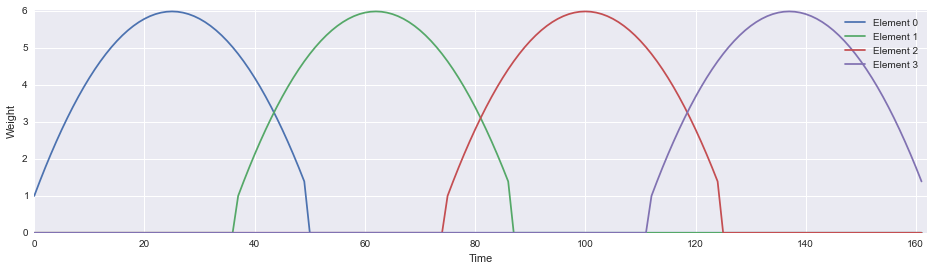

In [50]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));
plt.plot(W.T);

plt.xlim(0, n_cov);
plt.ylim(0, max(W) + 0.05);
plt.xlabel('Time');
plt.ylabel('Weight');
plt.legend(['Element ' + str(i) for i in range(k)]);

## Learn covariance dictionary using ALS vs. ADMM

#### Run ALS

In [51]:
reload(covdict) 
als = covdict.CovarianceDictionary(k=k, method='als', verbose=True, time=True, nls_beta=0.1, psdls_beta=0.1)
t = time.time()
Wals = als.fit_transform(X)
print str(time.time() - t) + ' seconds'

Initial gradient norm: 5215.765105.
Iter: 0. Projected gradient norm: 5215.765105. Objective: 0.985251.
Iter: 1. Projected gradient norm: 0.065866. Objective: 0.058467.
Iter: 2. Projected gradient norm: 0.066012. Objective: 0.005377.
Iter: 3. Projected gradient norm: 0.064287. Objective: 0.000672.
Iter: 4. Projected gradient norm: 0.066078. Objective: 0.000109.
Iter: 5. Projected gradient norm: 0.062214. Objective: 0.000033.
Iter: 6. Projected gradient norm: 0.072860. Objective: 0.000024.
Iter: 7. Projected gradient norm: 0.057140. Objective: 0.000022.
Iter: 8. Projected gradient norm: 0.058471. Objective: 0.000022.
Iter: 9. Final projected gradient norm 0.050719. Final objective 0.000019.
4.05049395561 seconds


#### Plot objective per iteration and final weights

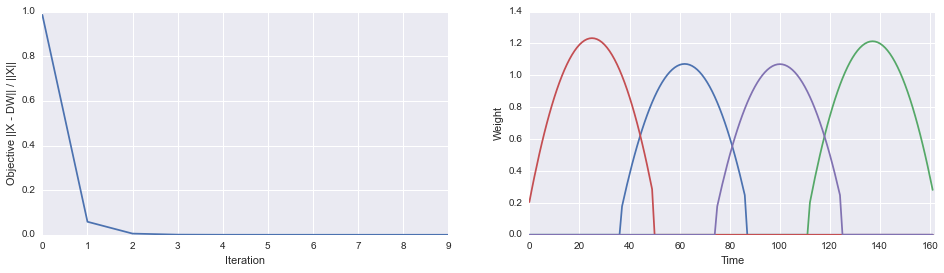

In [52]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(als.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wals.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');

#### Compare ALS-learned and true dictionary elements

In [53]:
# Match ALS-learned and corresponding dictionary elements, based on weight peaks
match_idx = argsort(argmax(Wals, axis=1))

# Correlate to account for scale factor
for a, b in zip(als.dictionary.T[match_idx], D.T):
    print corrcoef(a[triu_indices(n)], b)[0, 1]

0.999999992654
0.999999999976
0.999999999986
0.999999927561


#### Run ADMM

In [69]:
# Convergence quite sensitive to alpha and gamma (penalty and step size parameters)
reload(covdict)
admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, time=True, admm_alpha=0.1)
t = time.time()
Wadmm = admm.fit_transform(X)
print str(time.time() - t) + ' seconds'

Iter: 0. Objective: 0.985251.
Iter: 10. Objective: 0.044409.
0.602317810059 seconds


#### Plot objective per iteration and final weights

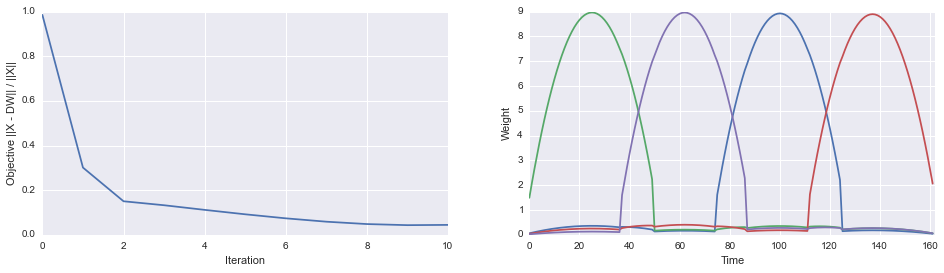

In [55]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(admm.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wadmm.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');

#### Compare ADMM-learned and true dictionary elements

In [56]:
# Match ADMM-learned and corresponding true dictionary elements, based on weight peaks
match_idx = argsort(argmax(Wadmm, axis=1))

# Correlate to account for scale factor
for a, b in zip(admm.dictionary.T[match_idx], D.T):
    print corrcoef(a[triu_indices(n)], b)[0, 1]

0.996694877946
0.996698384951
0.996205832558
0.996479460793


#### Compare objective over time for ALS vs. ADMM

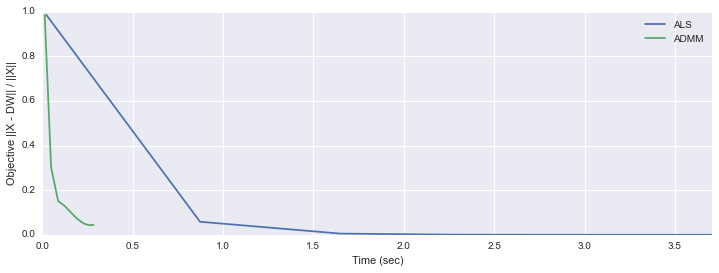

In [57]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4));
plt.plot(als.times, als.objective);
plt.plot(admm.times, admm.objective);
plt.xlim(0, max((admm.times[-1], als.times[-1])));
plt.xlabel('Time (sec)');
plt.ylabel('Objective ||X - DW|| / ||X||');
plt.legend(['ALS', 'ADMM']);

## Simulate multivariate Gaussian data

#### Draw samples from multivariate Gaussian and compute sample covariances

In [63]:
# Number of samples drawn per covariance matrix
n_samp = 2 * n

# Ignore non-PSD warnings due to numerical error (negative eigenvalues on order of 1e-17)
data = hstack([multivariate_normal(zeros(n), X.T[i], n_samp).T for i in range(n_cov)])

# Compute sample covariance matrices
Xsample = dstack([cov(chunk) for chunk in hsplit(data, n_cov)])

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: covariance is not positive-semidefinite.


#### Learn dictionary using ALS

In [76]:
als = covdict.CovarianceDictionary(k=k, method='als', verbose=True, time=True, nls_beta=0.5, psdls_beta=0.5)
t = time.time()
Wals = als.fit_transform(Xsample)
print str(time.time() - t) + ' seconds'

Initial gradient norm: 5210.882572.
Iter: 0. Projected gradient norm: 5210.882572. Objective: 0.988464.
Iter: 1. Final projected gradient norm 0.029431. Final objective 0.390368.
0.982946157455 seconds


#### Plot objective per iteration and final weights

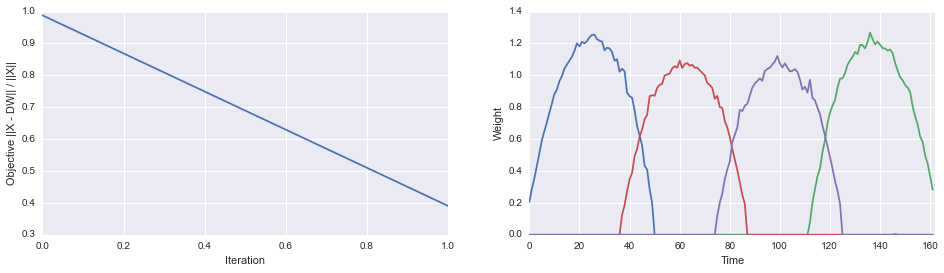

In [77]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(als.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wals.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');

#### Compare ALS-learned and true dictionary elements

In [66]:
# Match ALS-learned and true dictionary elements, based on weight peaks
match_idx = argsort(argmax(Wals, axis=1))

# Correlate to account for scale factor
print "Correlations between ALS-learned and true dictionary elements:"
for a, b in zip(als.dictionary.T[match_idx], D.T):
    print corrcoef(a[triu_indices(n)], b)[0, 1]

Correlations between ALS-learned and true dictionary elements:
0.99733268477
0.997232869006
0.997062579744
0.997325530681


#### Learn dictionary using ADMM

In [70]:
admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, time=True, admm_alpha=0.1)
t = time.time()
Wadmm = admm.fit_transform(Xsample)
print str(time.time() - t) + ' seconds'

Iter: 0. Objective: 0.988464.
Iter: 10. Objective: 0.388352.
0.631433963776 seconds


#### Plot objective per iteration and final weights

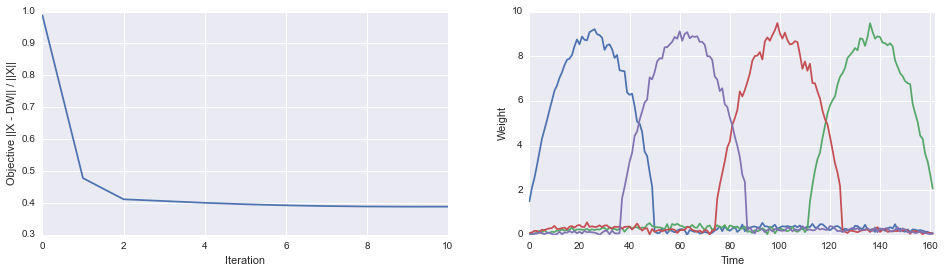

In [71]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(admm.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wadmm.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');

#### Compare ADMM-learned and true dictionary elements

In [73]:
# Match ADMM-learned to corresponding dictionary elements, based on weight peaks
match_idx = argsort(argmax(Wadmm, axis=1))

# Correlate to account for scale factor.
print "Correlations between ADMM-learned and true dictionary elements:"
for a, b in zip(admm.dictionary.T[match_idx], D.T):
    print corrcoef(a[triu_indices(n)], b)[0, 1]

Correlations between ADMM-learned and true dictionary elements:
0.993462730924
0.993487203194
0.992949002757
0.993470030655


#### Compare objective over time for ALS vs. ADMM

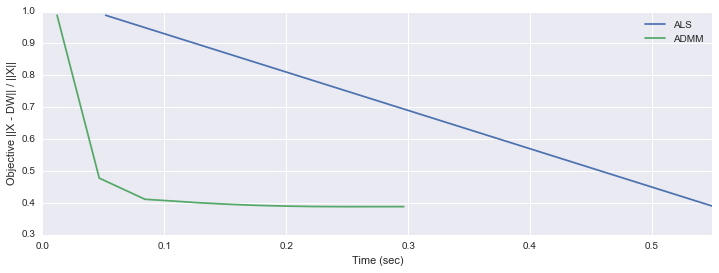

In [78]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4));
plt.plot(als.times, als.objective);
plt.plot(admm.times, admm.objective);
plt.xlim(0, max((admm.times[-1], als.times[-1])));
plt.xlabel('Time (sec)');
plt.ylabel('Objective ||X - DW|| / ||X||');
plt.legend(['ALS', 'ADMM']);